In [101]:
# load json config my-config.json
def load_config():
    config = {}
    import json
    with open('my-config.json') as json_file:
        config = json.load(json_file)
        # print(config)
    return config


['http://app2.test:8666/test-sql.json', 'http://app2.test:8666/news', 'http://php-lh.test:3666/news', 'http://php-lh.test:3666/test-sql.json']
[100, 200, 400, 800, 1600, 3200]
This is ApacheBench, Version 2.3 <$Revision: 1903618 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking app2.test (be patient).....done


Server Software:        nginx
Server Hostname:        app2.test
Server Port:            8666

Document Path:          /test-sql.json?limit=100
Document Length:        11270 bytes

Concurrency Level:      1
Time taken for tests:   1.293 seconds
Complete requests:      100
Failed requests:        70
   (Connect: 0, Receive: 0, Length: 70, Exceptions: 0)
Total transferred:      1146846 bytes
HTML transferred:       1126846 bytes
Requests per second:    77.34 [#/sec] (mean)
Time per request:       12.929 [ms] (mean)
Time per request:       12.929 [ms] (mean, across all concurre

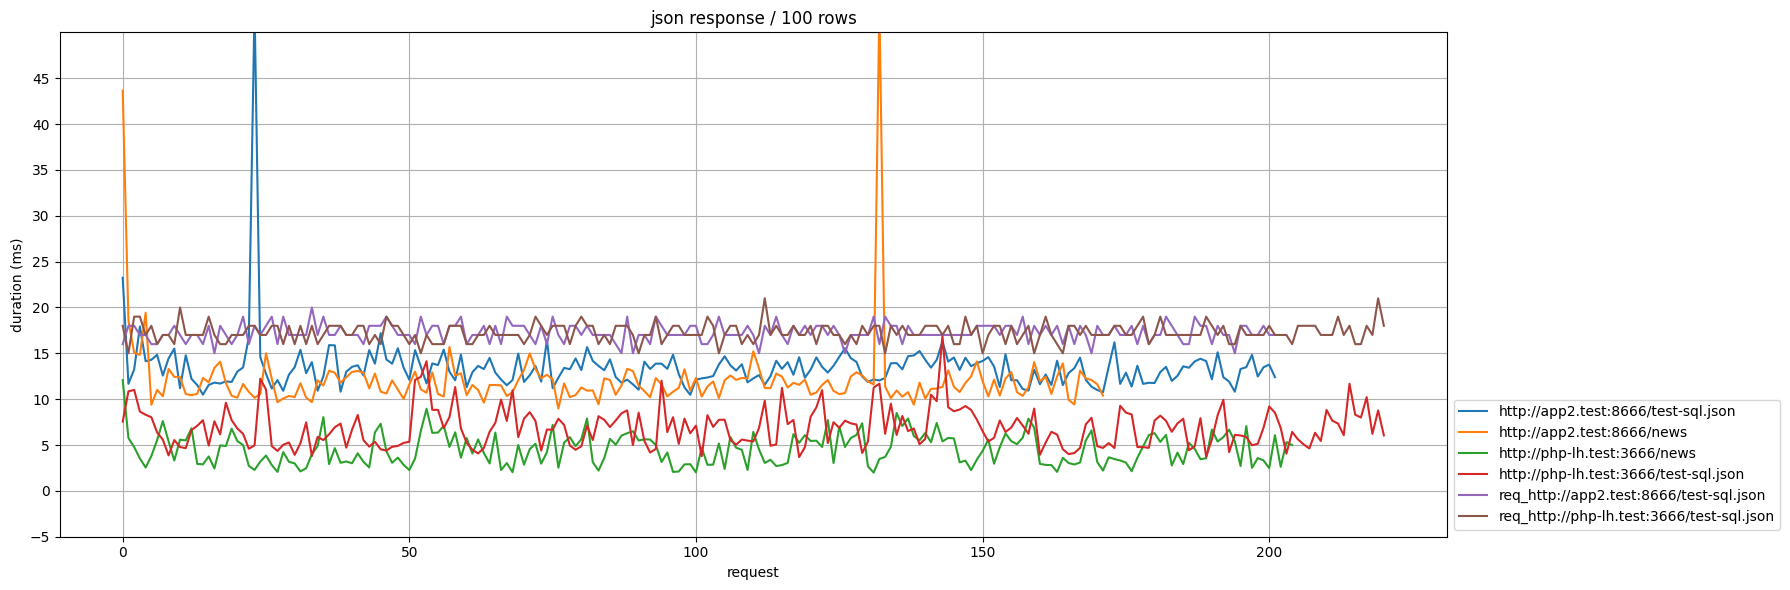

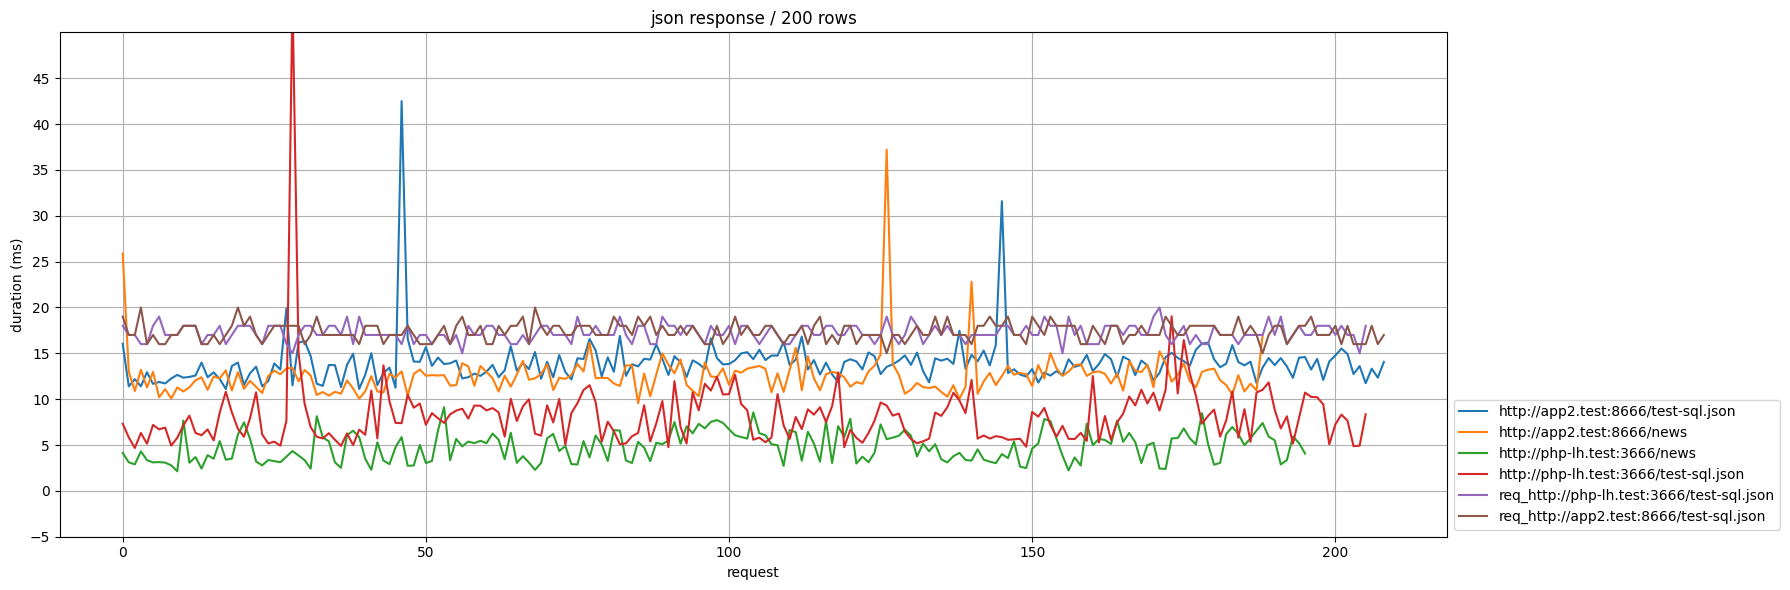

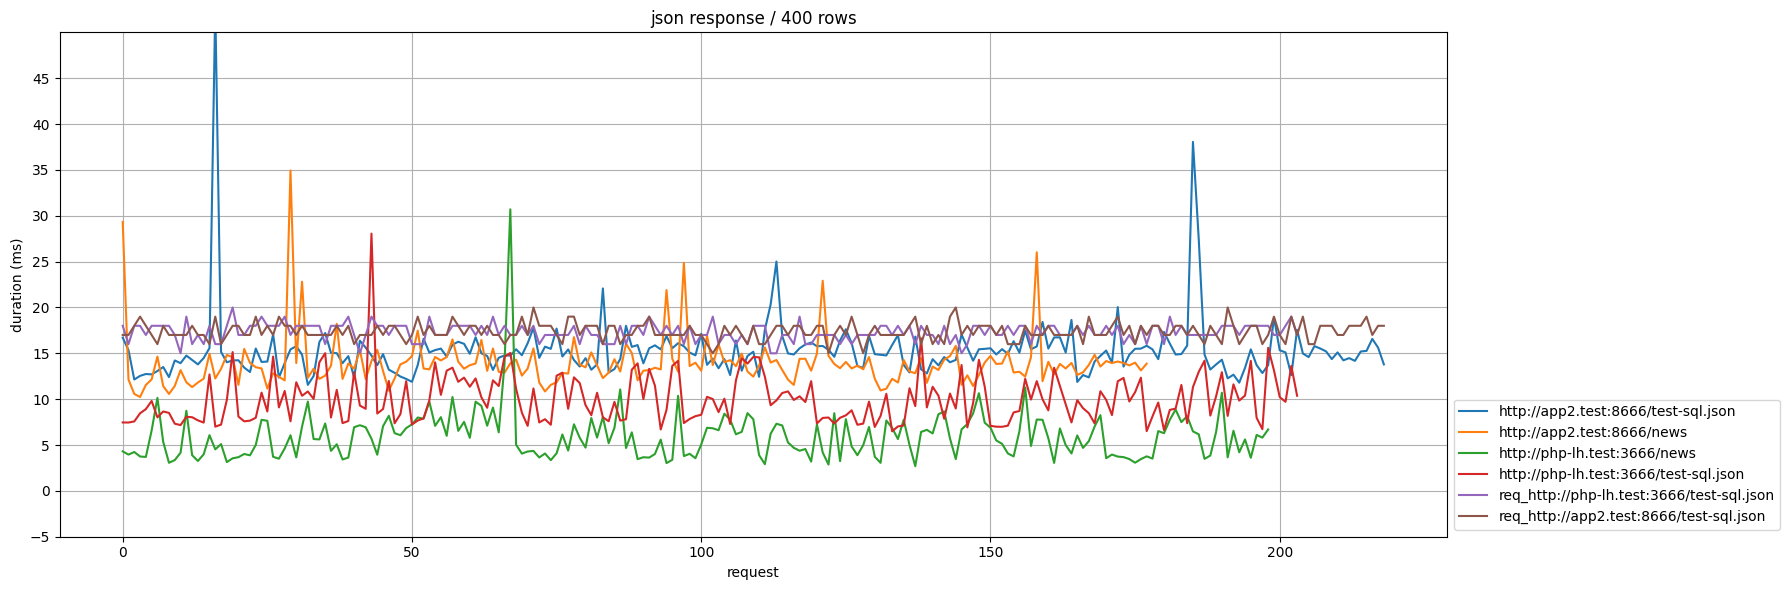

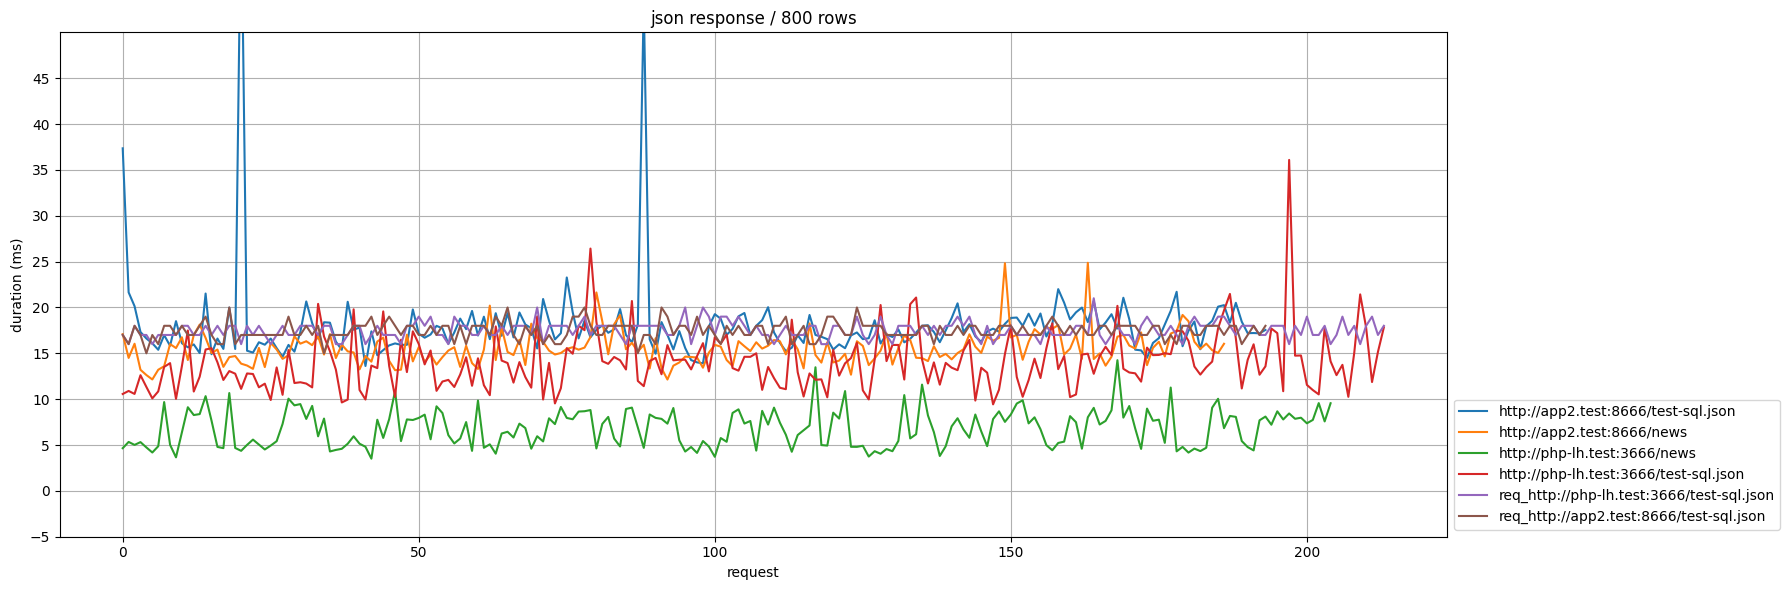

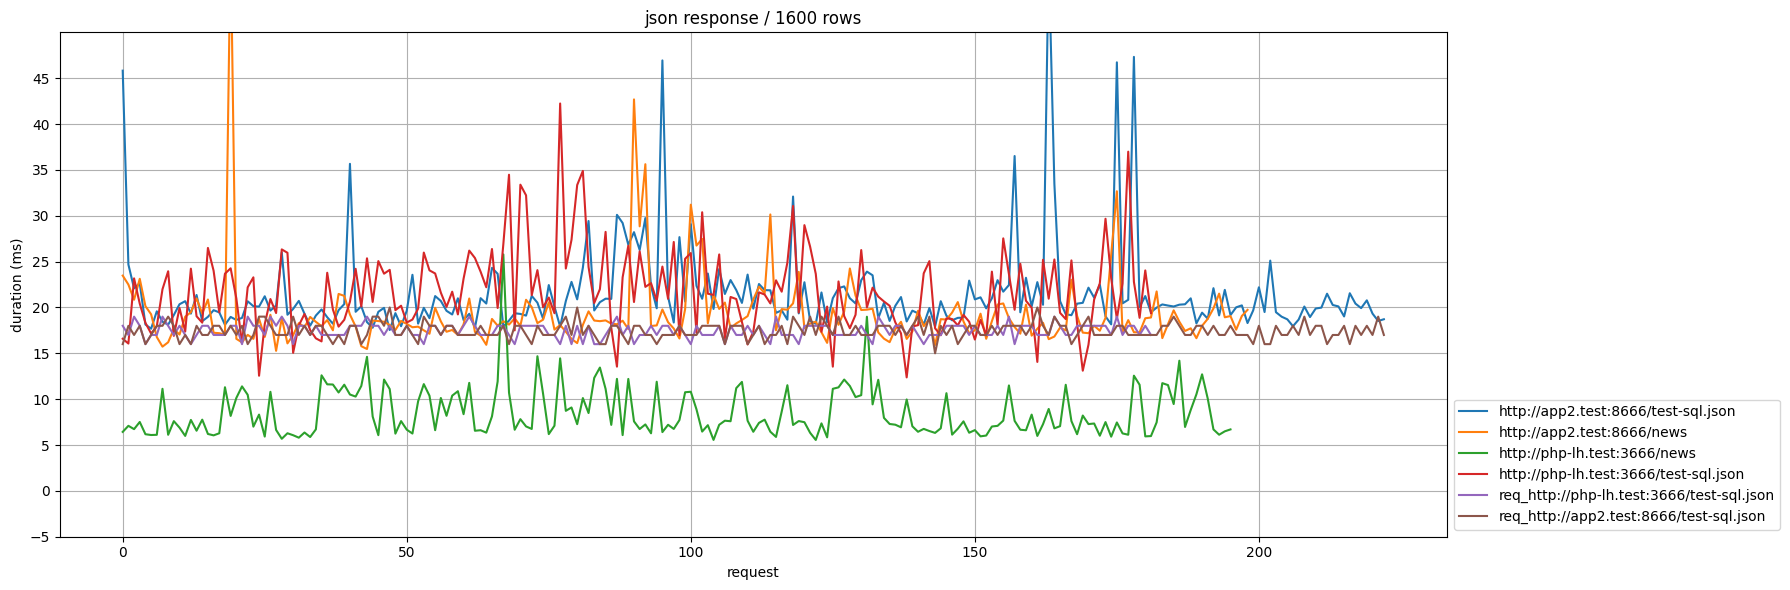

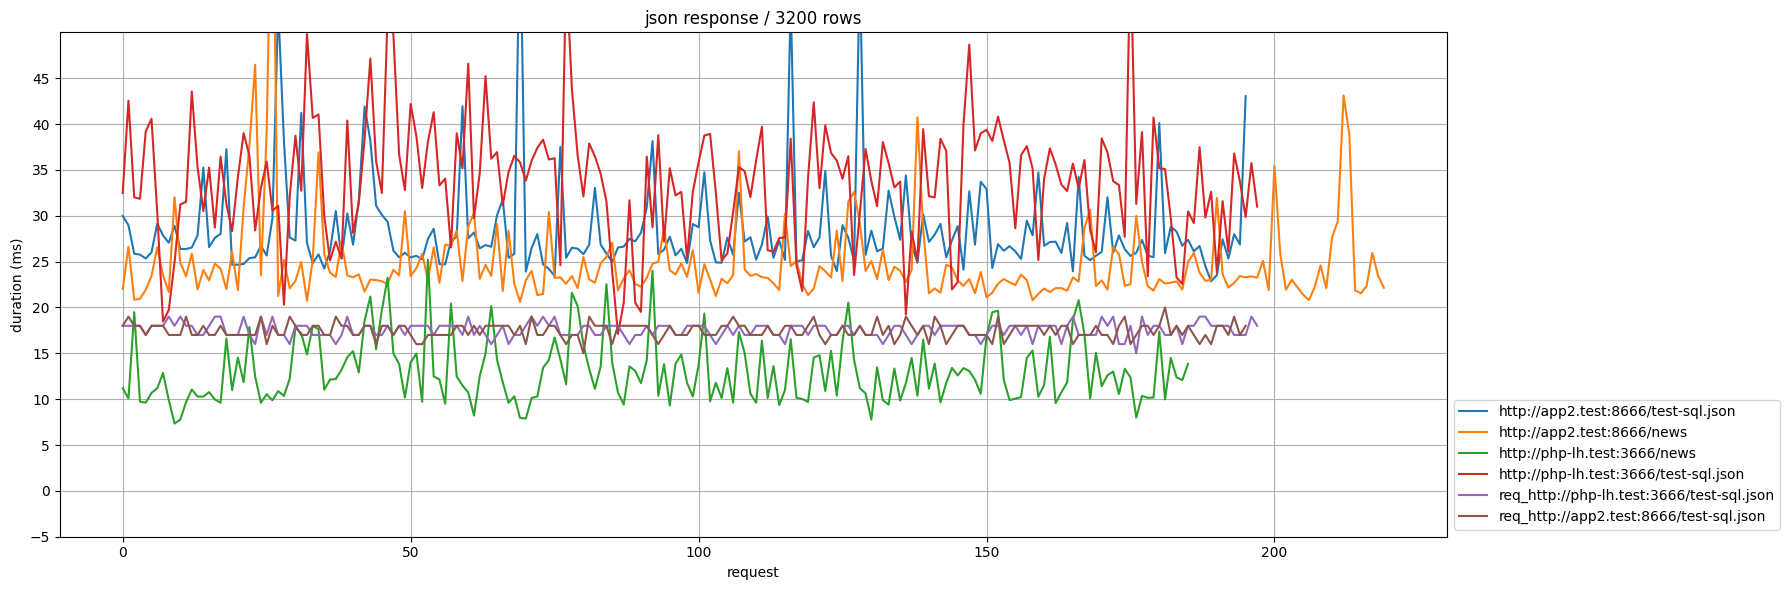

In [102]:

# send 1000 requests mixing the targets randomly
# compute each target response time
# plot the results

import random
import requests
import time
import hashlib

# disable https warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# WARNING: https can be slower and chaotic than http 🤔
def send_requests_randomly(targets, nb_requests, limit):
    durations = {}
    # init durations for each target
    for target in targets:
        durations[target] = []

    for i in range(nb_requests):
        target = random.choice(targets)
        start = time.time()
        # md5 hash of start
        md5hash = hashlib.md5(str(start).encode('utf-8')).hexdigest()
        # add limit as GET parameter
        url = f'{target}?limit={limit}&md5={md5hash}'

        # send request, no https verify
        response = requests.get(url, verify=False)

        end = time.time()
        duration = 1000 * (end - start)
        # store duration for target
        durations[target].append(duration)
        # print(f'{i} {url} {duration:.2f}ms')

        # check if response body is valid json
        try:
            response_json = response.json()
            # get count_request from response_json if exists
            if 'count_request' in response_json:
                # check if key 'ref_{target}' exists in durations
                if f'req_{target}' not in durations:
                    durations[f'req_{target}'] = []

                count_request = response_json['count_request']
                # add count_request to durations
                durations[f'req_{target}'].append(count_request)
                # print(f'count_request: {count_request} {url}')
        except:
            # print(f'ERROR: {url} response body is not valid json')
            # print(response.text)
            continue

        # save response body to file
        target_name = target.replace('http://', '')
        target_name = target_name.replace('https://', '')
        # remove port by replacing : with -
        target_name = target_name.replace(':', '-')
        target_name = target_name.replace('/', '-')

        target_file = f'my-json/{limit}-{target_name}.json'
        with open(target_file, 'w') as f:
            # get response body
            body = response.text
            # write to file
            f.write(body)
            f.write('\n')

    return durations


import matplotlib.pyplot as plt
import numpy as np

def run_test(targets, nb_requests, limit, config):
    
    requests = send_requests_randomly(targets, nb_requests, limit)

    for target, durations in requests.items():
        # max len 50 chars for target
        label_target = target[:50]
        plt.plot(durations, label=label_target)

    # add title
    plt.title(f'json response / {limit} rows')
    # add x axis label
    plt.xlabel('request')
    # add y axis label
    plt.ylabel('duration (ms)')
    # ymax is 5 + sqrt(limit/2)   
    #ymax = 8 + np.sqrt(limit/1.5)
    # zoom on y axis from 0 to ymax 
    # if ymax not None then use it
    if 'ymax' in config:
        ymax = config['ymax']
        plt.ylim(0, ymax)

    # add y axis ticks every 5 
    plt.yticks(np.arange(-5, ymax, 5)) 
    # plt.yticks() 

    # add grid
    plt.grid(True)
    # add legend outside of chart at bottom left
    plt.legend(bbox_to_anchor=(1.0, 0), loc='lower left')

    # compute chart bounding box with legend outside
    plt.gcf().set_figwidth(12)
    plt.gcf().set_figheight(6)
    plt.tight_layout(rect=[0, 0, 1.5, 1])

    # save chart to file {limit}rows.png with size 1200x600
    plt.savefig(f'my-img/{limit}rows.png', bbox_inches='tight')

    # plt.savefig(f'my-img/{limit}rows.png')
    # build and show chart
    plt.show()

# DON'T FORGET TO START THE SERVERS BEFORE...
config = load_config()
targets = config['targets']

# strip empty spaces targets
targets = [target.strip() for target in targets]

# remove targets with not starting with http
targets = [target for target in targets if target.startswith('http')]

# if config['https'] is false then convert https to http at the beginning of each target
if not config['https']:
    targets = [target.replace('https://', 'http://') for target in targets]

print(targets)

# CLI
# php artisan serve --host=laravel-localhost.test --port=3555
# Apache Bench
# ab -n100 http://app2.test:8666

limits = [100, 200, 400, 800, 1600, 3200]
if config['limits'] is not None:
     limits = config['limits']

print(limits)

# limits = [ 100 ]
nb_requests = 200 * len(targets)

# create dir my-json if not exists
!mkdir -p ./my-json
!mkdir -p ./my-img

# remove all my-*json files
!rm ./my-json/*.json

# loop over limits
for limit in limits:
    # for each target launch request with ab
    for target in targets:
        !ab -n100 "{target}?limit={limit}"


for limit in limits:
    # run test for each limit
    run_test(targets, nb_requests, limit, config)



